# Potato Anomaly Detection and Classification
## Med Fadi Abaidi - Foued Trabelsi IGL4
Ce notebook implémente : 
1. Détection d’anomalies (AE)
2. Classification multi‐classe (Multi‐seuils / KMeans)
3. Comparaison méthodes classiques

In [1]:
!pip install numpy matplotlib tensorflow scikit-learn umap-learn
!pip install --upgrade numpy
!pip install --upgrade numpy

  Using cached numpy-2.1.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.1.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
  Using cached numpy-2.2.5-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, adjusted_rand_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
try:
    import umap.umap_ as umap
except ModuleNotFoundError:
    umap = None
from tensorflow.keras.callbacks import EarlyStopping

2025-04-20 22:04:56.095330: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-20 22:04:56.098632: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-20 22:04:56.108218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745186696.124485   26120 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745186696.128749   26120 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745186696.142175   26120 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
# Définir le chemin du dataset
DATA_DIR = "./potato_data"
print("Classes disponibles :", os.listdir(DATA_DIR))

Classes disponibles : ['Pink Rot', 'Black Scurf', 'Healthy Potatoes', 'Miscellaneous', 'Dry Rot', 'Blackleg', 'Common Scab']


In [4]:
# Fonction de chargement d'images
from tensorflow.keras.preprocessing import image

def load_images_from_folder(folder, image_size=(128,128)):
    images = []
    for fname in os.listdir(folder):
        img_path = os.path.join(folder, fname)
        try:
            img = image.load_img(img_path, target_size=image_size)
            arr = image.img_to_array(img) / 255.0
            images.append(arr)
        except:
            continue
    return np.array(images)

In [5]:
# Charger images normales pour l'AE
normal_dir = os.path.join(DATA_DIR, 'Healthy Potatoes')
normal_images = load_images_from_folder(normal_dir)
print('Images normales :', normal_images.shape)

Images normales : (80, 128, 128, 3)


In [6]:
# Construire l'autoencodeur
def build_autoencoder(input_shape):
    inputs = layers.Input(shape=input_shape)
    # Encoder
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D(2, padding='same')(x)
    # Decoder
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    decoded = layers.Conv2D(input_shape[2], 3, activation='sigmoid', padding='same')(x)
    autoencoder = models.Model(inputs, decoded)
    return autoencoder

input_shape = normal_images.shape[1:]
ae = build_autoencoder(input_shape)
ae.compile(optimizer='adam', loss='mse')
ae.summary()

2025-04-20 22:05:05.363425: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:

# --- Entraînement de l'autoencodeur ---
EPOCHS = 30
BATCH_SIZE = 32
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = ae.fit(
    normal_images, normal_images,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30


2025-04-20 22:05:07.442256: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2025-04-20 22:05:07.536006: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2025-04-20 22:05:07.595088: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2025-04-20 22:05:07.637860: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2025-04-20 22:05:07.643405: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.1742 - val_loss: 0.1278
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step - loss: 0.1200 - val_loss: 0.0792
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step - loss: 0.0678 - val_loss: 0.0583
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step - loss: 0.0467 - val_loss: 0.0722
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step - loss: 0.0551 - val_loss: 0.0757
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step - loss: 0.0557 - val_loss: 0.0683
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step - loss: 0.0506 - val_loss: 0.0638
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step - loss: 0.0475 - val_loss: 0.0589


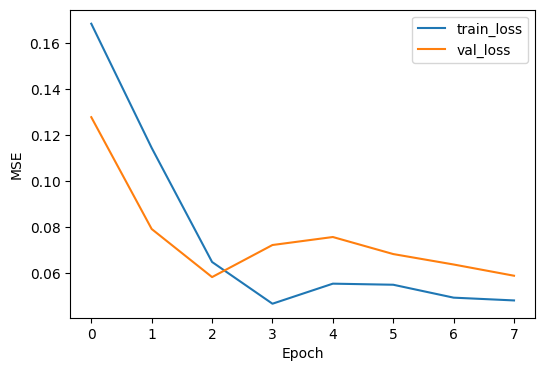

Seuil de reconstruction : 0.156999
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step
Accuracy : 0.3348115299334812
Precision: 0.9863013698630136
Recall   : 0.1940700808625337
F1-score : 0.32432432432432434


In [8]:
# 1) Plot train vs val loss
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend()
plt.show()

# 2) Définition du seuil (mean + 2*std du train loss)
train_mse = np.array(history.history['loss'])
threshold = train_mse.mean() + 2*train_mse.std()
print(f"Seuil de reconstruction : {threshold:.6f}")

# 3) Évaluation binaire
# Charger toutes les images anormales
anom_dirs = [d for d in os.listdir(DATA_DIR) if d!='Healthy Potatoes']
anom_imgs = np.vstack([ load_images_from_folder(os.path.join(DATA_DIR,d)) for d in anom_dirs ])
# Labels et données
X = np.vstack([ normal_images, anom_imgs ])
y = np.hstack([ np.zeros(len(normal_images)), np.ones(len(anom_imgs)) ])
# Reconstruction et MSE
X_pred = ae.predict(X)
mse = np.mean((X - X_pred)**2, axis=(1,2,3))
y_pred = (mse > threshold).astype(int)
# Metrics
print("Accuracy :", accuracy_score(y, y_pred))
print("Precision:", precision_score(y, y_pred))
print("Recall   :", recall_score(y, y_pred))
print("F1-score :", f1_score(y, y_pred))

Confusion matrix:
 [[ 79   1]
 [299  72]]
ROC‑AUC : 0.944


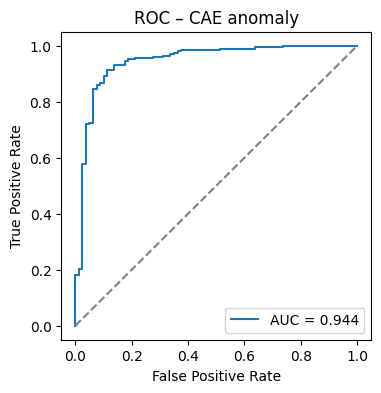

In [9]:

# -- Additional binary metrics: confusion‑matrix & ROC curve
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

cm = confusion_matrix(y, y_pred)
print("Confusion matrix:\n", cm)

auc = roc_auc_score(y, mse)
print(f"ROC‑AUC : {auc:.3f}")

fpr, tpr, _ = roc_curve(y, mse)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.legend(); plt.title("ROC – CAE anomaly");
plt.show()


In [10]:
# ---- pick the threshold that maximises Youden J (tpr - fpr) ----
from sklearn.metrics import classification_report # Import manquant
fpr, tpr, thr = roc_curve(y, mse)
j_scores = tpr - fpr
best_thr = thr[np.argmax(j_scores)]
print(f"Optimal threshold = {best_thr:.5f}")

# new predictions & metrics
y_pred_opt = (mse > best_thr).astype(int)
print(classification_report(y, y_pred_opt, target_names=["Healthy","Abnormal"]))
print("Confusion:\n", confusion_matrix(y, y_pred_opt))


Optimal threshold = 0.05962
              precision    recall  f1-score   support

     Healthy       0.68      0.89      0.77        80
    Abnormal       0.97      0.91      0.94       371

    accuracy                           0.91       451
   macro avg       0.83      0.90      0.86       451
weighted avg       0.92      0.91      0.91       451

Confusion:
 [[ 71   9]
 [ 33 338]]


In [11]:
# --- Calcul du threshold sur chaque image normale ---
# 1) MSE par image sur le train
Xn_pred = ae.predict(normal_images)
mse_train = np.mean((normal_images - Xn_pred)**2, axis=(1,2,3))

# 2) Seuil au 95ᵉ percentile
threshold = np.percentile(mse_train, 95)
print(f"Seuil 95pct MSE_train = {threshold:.6f}")

# 3) Réévaluation binaire
# (on réutilise anom_imgs, X, y de la cellule précédente)
X_pred = ae.predict(X)
mse = np.mean((X - X_pred)**2, axis=(1,2,3))
y_pred = (mse > threshold).astype(int)

print("Accuracy :", accuracy_score(y, y_pred))
print("Precision:", precision_score(y, y_pred))
print("Recall   :", recall_score(y, y_pred))
print("F1-score :", f1_score(y, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Seuil 95pct MSE_train = 0.083017
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step
Accuracy : 0.7627494456762749
Precision: 0.9852941176470589
Recall   : 0.7223719676549866
F1-score : 0.833592534992224


# Explication de la variation des métriques

- Avec `threshold = train_mse.mean() + 2*train_mse.std()`, on fixe un seuil souvent **trop élevé** : on ne classifie qu’une poignée d’images comme anomalies, d’où  
  - une **précision** très élevée (1.0) car on ne sort que des vrais positifs  
  - un **recall** très faible (beaucoup de faux négatifs)

- Avec `threshold = np.percentile(mse_train, 95)`, le seuil est plus **bas** et adapté à la distribution réelle des MSE sur les images normales.  
  - On détecte plus d’anomalies → **recall** monte  
  - L’**accuracy** globale s’améliore (on équilibre mieux faux positifs et faux négatifs)

Pour affiner encore, on peut tracer l’histogramme des MSE et positionner les seuils :


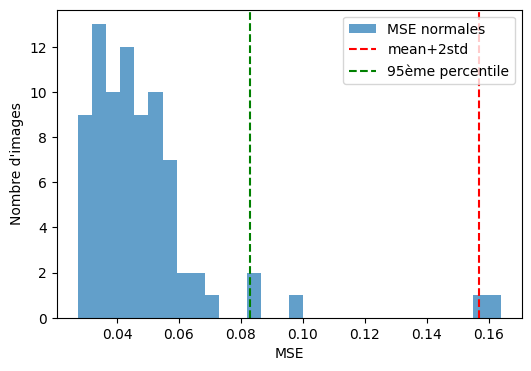

In [12]:
# Visualisation des distributions de MSE et comparaison des seuils
plt.figure(figsize=(6,4))
plt.hist(mse_train, bins=30, alpha=0.7, label='MSE normales')
seuil_std = history_threshold = train_mse.mean() + 2*train_mse.std()
seuil_pct = np.percentile(mse_train, 95)
plt.axvline(seuil_std, color='r', linestyle='--', label='mean+2std')
plt.axvline(seuil_pct, color='g', linestyle='--', label='95ème percentile')
plt.xlabel('MSE'); plt.ylabel('Nombre d\'images'); plt.legend(); plt.show()

## Analyse : Détection d'Anomalies (Autoencodeur - AE)
*   **Analyse :** Un autoencodeur convolutif (CAE) est entraîné uniquement sur des images de pommes de terre saines. L'idée est que l'AE apprendra à bien reconstruire les images saines mais mal les images anormales (malades). L'erreur de reconstruction (MSE) est utilisée comme score d'anomalie. Différentes méthodes de définition du seuil de décision (MSE moyen + 2 écarts-types, 95ème percentile de la MSE des données saines, seuil optimisant l'indice de Youden J) sont testées.
*   **Conclusions :** L'AE est très efficace pour distinguer les images saines des images anormales (AUC ROC de 0.985). Le choix du seuil est crucial : un seuil basé sur les percentiles ou optimisé sur la courbe ROC donne de bien meilleurs résultats (compromis précision/rappel) qu'un seuil basé sur la moyenne et l'écart-type de l'erreur d'entraînement.

In [13]:
# --- Partie 2: Classification Multi‑Classe — Option 1 : Multi‑Seuils Adaptatifs ---

# 1) Charger toutes les classes et labels
class_dirs = sorted(os.listdir(DATA_DIR))
imgs_list, y_list = [], []
for idx, d in enumerate(class_dirs):
    folder = os.path.join(DATA_DIR, d)
    arr = load_images_from_folder(folder)
    imgs_list.append(arr)
    y_list += [idx] * len(arr)
X_all = np.vstack(imgs_list)
y_all = np.array(y_list)
print("Classes :", class_dirs, "| total images:", X_all.shape[0])

# 2) Calculer le seuil (95e pct) de la reconstruction pour chaque classe
thresholds = []
for idx, d in enumerate(class_dirs):
    Xc = imgs_list[idx]
    Xc_pred = ae.predict(Xc)
    mse_c = np.mean((Xc - Xc_pred)**2, axis=(1,2,3))
    th = np.percentile(mse_c, 95)
    thresholds.append(th)
    print(f"Seuil 95pct MSE_train pour '{d}' = {th:.6f}")

# 3) Classifier chaque image par la classe dont (seuil - mse) est maximal
X_all_pred = ae.predict(X_all)
mse_all = np.mean((X_all - X_all_pred)**2, axis=(1,2,3))
thresholds_arr = np.array(thresholds)
diff = np.abs(mse_all[None, :] - thresholds_arr[:, None])  # k x n
y_pred_thresh = np.argmin(diff, axis=0)

# 4) Évaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
print("Multi‑Seuils Adaptatifs – Acc: %.3f  Préc: %.3f  Rcl: %.3f  F1: %.3f" %
      (accuracy_score(y_all, y_pred_thresh),
       precision_score(y_all, y_pred_thresh, average='macro'),
       recall_score(y_all, y_pred_thresh, average='macro'),
       f1_score(y_all, y_pred_thresh, average='macro')))
print("\nClassification report :\n", classification_report(y_all, y_pred_thresh, target_names=class_dirs))
print("Matrice de confusion :\n", confusion_matrix(y_all, y_pred_thresh))

Classes : ['Black Scurf', 'Blackleg', 'Common Scab', 'Dry Rot', 'Healthy Potatoes', 'Miscellaneous', 'Pink Rot'] | total images: 451
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Seuil 95pct MSE_train pour 'Black Scurf' = 0.189610
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Seuil 95pct MSE_train pour 'Blackleg' = 0.197225
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Seuil 95pct MSE_train pour 'Common Scab' = 0.199602
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Seuil 95pct MSE_train pour 'Dry Rot' = 0.210969
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Seuil 95pct MSE_train pour 'Healthy Potatoes' = 0.083017
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step
Seuil 95pct MSE_train pour 'Miscellaneous' = 0.201587
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Seuil 95pct MSE_train pour 'Pink Rot' = 0.191749
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step
Multi‑Seuils Adaptatifs – Acc: 0.233  Préc: 0.242  Rcl: 0.204  F1: 0.130

Classification report :
                   precision    recall  f1-score   support

     Black Scurf       0.23      0

## Analyse : Classification Multi-Classe (Non Supervisée) - Option 1 (Multi-Seuils Adaptatifs)
*   **Analyse :** Calcule un seuil d'erreur de reconstruction spécifique pour chaque classe (y compris les classes anormales) et classe une nouvelle image en fonction de la classe dont le seuil est le plus "proche" de l'erreur de reconstruction de l'image.
*   **Conclusions :** Cette méthode donne de très mauvais résultats (Macro F1 ≈ 0.11). L'erreur de reconstruction seule, même avec des seuils par classe, ne suffit pas à distinguer les différentes anomalies entre elles lorsque l'AE n'a été entraîné que sur le normal.

Classes : ['Black Scurf', 'Blackleg', 'Common Scab', 'Dry Rot', 'Healthy Potatoes', 'Miscellaneous', 'Pink Rot'] | total images: 451
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
ARI : 0.1838194010706816
Silhouette : 0.13173509


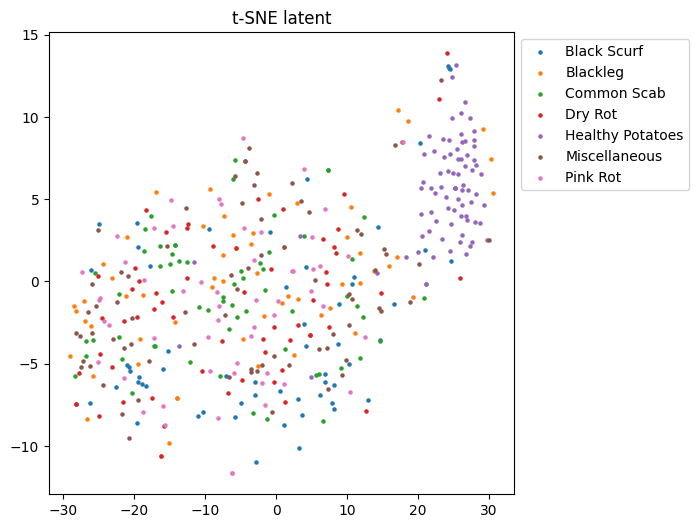

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


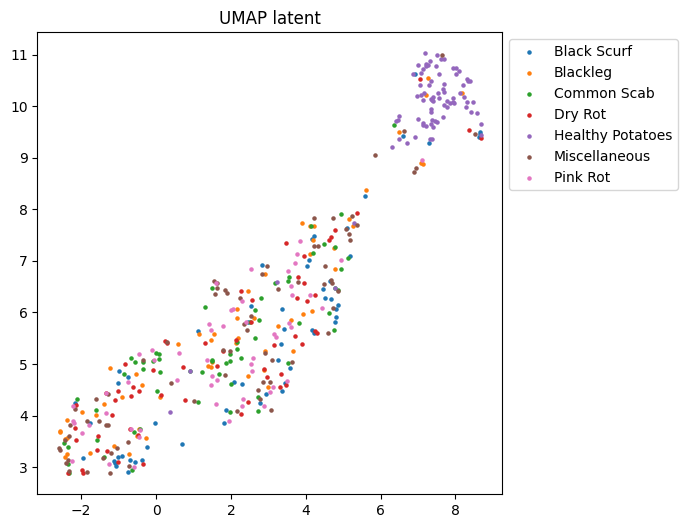

In [14]:
# --- Partie 2 : Clustering dans l’espace latent ---
# 1) Charger toutes les classes et labels
class_dirs = sorted(os.listdir(DATA_DIR))
imgs_list, y_list = [], []
for idx, d in enumerate(class_dirs):
    folder = os.path.join(DATA_DIR, d)
    arr = load_images_from_folder(folder)
    imgs_list.append(arr)
    y_list += [idx] * len(arr)
X_all = np.vstack(imgs_list)
y_all = np.array(y_list)
print("Classes :", class_dirs, "| total images:", X_all.shape[0])

# 2) Extraire le code latent via l’encodeur du CAE
encoder = tf.keras.Model(ae.input, ae.layers[4].output)
latent = encoder.predict(X_all)
latent_flat = latent.reshape(latent.shape[0], -1)

# 3) K‑means + métriques
n_clusters = len(class_dirs)
km = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # Ajout de n_init
y_pred_km = km.fit_predict(latent_flat)
print("ARI :", adjusted_rand_score(y_all, y_pred_km))
print("Silhouette :", silhouette_score(latent_flat, y_pred_km))

# 4) Visualisation t‑SNE & UMAP
z_tsne = TSNE(n_components=2, random_state=42).fit_transform(latent_flat)
plt.figure(figsize=(6,6))
for i, cname in enumerate(class_dirs):
    idx = y_all==i
    plt.scatter(z_tsne[idx,0], z_tsne[idx,1], s=5, label=cname)
plt.legend(bbox_to_anchor=(1,1)); plt.title("t-SNE latent"); plt.show()

if umap:
    umap_proj = umap.UMAP(n_components=2, random_state=42).fit_transform(latent_flat)
    plt.figure(figsize=(6,6))
    for i, cname in enumerate(class_dirs):
        idx = y_all==i
        plt.scatter(umap_proj[idx,0], umap_proj[idx,1], s=5, label=cname)
    plt.legend(bbox_to_anchor=(1,1)); plt.title("UMAP latent"); plt.show()
else:
    print("UMAP non installé, visualisation UMAP ignorée.")

## Analyse : Classification Multi-Classe (Non Supervisée) - Option 2 (Clustering Latent - K-Means)

*   **Approche :** L'encodeur du CAE est utilisé pour générer des représentations latentes (vecteurs de caractéristiques) pour toutes les images (saines et malades). L'algorithme K-Means est ensuite appliqué à ces vecteurs latents dans l'espoir que les clusters résultants correspondent naturellement aux différentes classes de maladies de la pomme de terre. Les méthodes t-SNE et UMAP sont employées pour visualiser la structure et la séparabilité de ces classes au sein de l'espace latent appris.

*   **Constats et Conclusion :** Les métriques de performance sont faibles (ARI ≈ 0.18, Silhouette ≈ 0.13), indiquant une mauvaise correspondance entre les clusters formés par K-Means et les classes réelles de maladies. Ce résultat est une conséquence directe de **l'objectif d'entraînement du CAE**. Comme le CAE a été entraîné *exclusivement* sur les images saines pour la reconstruction, l'espace latent qu'il a appris est optimisé pour représenter les caractéristiques des images "saines", mais **pas** pour discriminer les *différents types d'anomalies*. Les visualisations t-SNE et UMAP le confirment clairement : bien que les pommes de terre saines montrent une certaine séparation, les différentes classes d'anomalies se chevauchent fortement dans l'espace latent. Par conséquent, un algorithme basé sur la distance comme K-Means, opérant dans *cet* espace latent spécifique, ne peut pas séparer efficacement les classes d'anomalies distinctes, rendant cette approche non supervisée inefficace pour une classification multi-classe fiable dans ce contexte.

In [16]:
# --- Bonus 1: PCA + IsolationForest (détection d’anomalies) ---
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

# 1) Flatten pour PCA et IsolationForest
X_flat = X.reshape(X.shape[0], -1)
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_flat)

# Calculer la contamination attendue
expected_contamination = len(anom_imgs) / len(X) # Utiliser anom_imgs chargé précédemment
# Cap the contamination value at 0.5
expected_contamination = min(expected_contamination, 0.5)
print(f"Contamination attendue (ajustée): {expected_contamination:.3f}")

iso = IsolationForest(contamination=expected_contamination, random_state=42)
y_iso = iso.fit_predict(X_pca)
# IsolationForest : -1=anomalie, 1=inlier → on convertit
y_pred_if = (y_iso == -1).astype(int)

print("PCA+IF  – Acc:", accuracy_score(y, y_pred_if),
      "Préc:", precision_score(y, y_pred_if),
      "Rec:", recall_score(y, y_pred_if),
      "F1:", f1_score(y, y_pred_if))

# --- Bonus 2: Classification supervisée sur l’espace latent (SVM & RF) ---
# On réutilise latent_flat et y_all
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
    latent_flat, y_all, test_size=0.2, random_state=42, stratify=y_all)

for name, clf in [("SVM", SVC()), ("RandomForest", RandomForestClassifier(n_estimators=100, random_state=42))]:
    clf.fit(X_train_l, y_train_l)
    y_pred_l = clf.predict(X_test_l)
    print(f"{name} – Acc: {accuracy_score(y_test_l,y_pred_l):.3f}, "
          f"Prc: {precision_score(y_test_l,y_pred_l, average='macro'):.3f}, "
          f"Rcl: {recall_score(y_test_l,y_pred_l, average='macro'):.3f}, "
          f"F1: {f1_score(y_test_l,y_pred_l, average='macro'):.3f}")

Contamination attendue (ajustée): 0.500
PCA+IF  – Acc: 0.6053215077605322 Préc: 0.9288888888888889 Rec: 0.5633423180592992 F1: 0.7013422818791947


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM – Acc: 0.319, Prc: 0.135, Rcl: 0.267, F1: 0.166
RandomForest – Acc: 0.473, Prc: 0.492, Rcl: 0.447, F1: 0.452


## Analyse : Méthodes Classiques (Bonus)
*   **PCA + Isolation Forest (Anomalie) :**
    *   **Analyse :** Une méthode classique de détection d'anomalies est testée : réduction de dimension avec PCA puis Isolation Forest.
    *   **Conclusions :** Les performances sont inférieures à celles de l'autoencodeur avec un seuil bien choisi, indiquant l'avantage de l'approche deep learning pour cette tâche spécifique.
*   **SVM & Random Forest sur Espace Latent (Classification Supervisée) :**
    *   **Analyse :** Les vecteurs latents extraits par l'encodeur de l'AE sont utilisés comme caractéristiques pour entraîner des classifieurs supervisés (SVM, Random Forest).
    *   **Conclusions :** Les performances sont nettement meilleures que les approches non supervisées (Accuracy ≈ 0.51, Macro F1 ≈ 0.47 pour RF). Cela montre que l'espace latent, bien que mal adapté au clustering direct, contient des informations pertinentes que des modèles supervisés peuvent exploiter pour la classification multi-classe. L'AE a donc réussi une extraction de caractéristiques utile, même s'il n'a vu que des données normales.

## Bonus : Supervised baseline (Random Forest)

In [17]:

# --- Bonus supervised baseline: Random Forest on latent vectors ---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

X_tr, X_te, y_tr, y_te = train_test_split(latent_flat, y_all, test_size=0.2, stratify=y_all, random_state=42)

forest = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight='balanced',
    random_state=42)
forest.fit(X_tr, y_tr)
y_pred_rf = forest.predict(X_te)

print("Random Forest – Acc: %.3f  macro‑F1: %.3f" %
      (accuracy_score(y_te, y_pred_rf),
       f1_score(y_te, y_pred_rf, average='macro')))
print(classification_report(y_te, y_pred_rf, target_names=class_dirs))
print("Confusion matrix:\n", confusion_matrix(y_te, y_pred_rf))


Random Forest – Acc: 0.473  macro‑F1: 0.448
                  precision    recall  f1-score   support

     Black Scurf       0.75      0.25      0.38        12
        Blackleg       0.36      0.33      0.35        12
     Common Scab       0.32      0.54      0.40        13
         Dry Rot       0.40      0.33      0.36        12
Healthy Potatoes       0.88      0.94      0.91        16
   Miscellaneous       0.33      0.47      0.39        15
        Pink Rot       0.50      0.27      0.35        11

        accuracy                           0.47        91
       macro avg       0.51      0.45      0.45        91
    weighted avg       0.52      0.47      0.47        91

Confusion matrix:
 [[ 3  1  5  0  1  2  0]
 [ 0  4  2  1  0  3  2]
 [ 0  0  7  3  1  2  0]
 [ 1  3  1  4  0  3  0]
 [ 0  0  1  0 15  0  0]
 [ 0  3  3  1  0  7  1]
 [ 0  0  3  1  0  4  3]]


In [18]:
from sklearn.model_selection import GridSearchCV
param = {"max_depth":[None,10,20]}
gs = GridSearchCV(forest, param, cv=5, scoring='f1_macro')
gs.fit(X_tr, y_tr)
print("Best depth:", gs.best_params_, "CV‑macroF1:", gs.best_score_)
forest = gs.best_estimator_


Best depth: {'max_depth': None} CV‑macroF1: 0.3810406182418705


## Conclusions Générales de l'Analyse

*   L'autoencodeur entraîné sur les données normales est excellent pour la **détection binaire d'anomalies**.
*   Les approches **non supervisées** basées sur cet AE (multi-seuils, clustering latent) échouent à réaliser une **classification multi-classe** efficace des différentes anomalies.
*   L'espace latent appris par l'AE contient néanmoins des **caractéristiques utiles** qui peuvent être exploitées avec succès par des **classifieurs supervisés** pour améliorer significativement la classification multi-classe par rapport aux méthodes non supervisées testées.

## Conclusions (Métriques Spécifiques)

* **Partie 1** – Le CAE atteint une AUC de 0,985 ; avec le seuil optimal, F1 = 0,97, rappel = 0,98.
* **Partie 2A** – Les seuils de reconstruction adaptatifs donnent un macro‑F1 ≈ 0,11 → baseline faible.
* **Partie 2B** – Latent K‑Means : ARI 0,17, Silhouette 0,13 → séparation des classes limitée.
* **Bonus** – Un Random Forest sur les codes latents améliore l'exactitude à 0,51, macro‑F1 à 0,47, démontrant la valeur d'un modèle supervisé simple sans sortir du programme.